In [3]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_validate

import seaborn as sns

import gc

pd.set_option('display.max_colwidth', 100)
%matplotlib inline
sns.set()

DATA_PATH = './data/'

In [ ]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}

In [ ]:
pprint(catalogue[100])

In [4]:
%%time
df_catalogue = pd.read_json(
    os.path.join(DATA_PATH, 'catalogue.json'), orient = 'index', typ = 'frame'
    )
df_catalogue.index.rename('element_uid', inplace = True)
df_catalogue.drop(['attributes', 'availability'], axis = 1, inplace = True)
print(df_catalogue.shape)

(10200, 7)
CPU times: user 1.66 s, sys: 19.2 ms, total: 1.68 s
Wall time: 1.69 s


In [5]:
df_catalogue = pd.get_dummies(df_catalogue, columns = ['type'])
df_catalogue.head()

,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type_movie,type_multipart_movie,type_series
element_uid,,,,,,,,,
0,80,2.912198e+07,0.575260,0,1.128332,0.654707,1,0,0
1,120,6.610431e+06,0.773224,3,1.112014,0.654707,1,0,0
10,100,1.666610e+07,0.700997,0,1.130076,0.654707,1,0,0
100,80,6.064739e+06,0.752751,4,0.953710,0.000000,1,0,0
1000,80,9.115019e+06,0.689883,0,1.128332,0.680410,1,0,0


In [6]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)
print (transactions.shape)

(9643012, 7)
CPU times: user 6.93 s, sys: 395 ms, total: 7.32 s
Wall time: 7.77 s


In [12]:
df_catalogue[(~df_catalogue.index.isin(transactions.element_uid)) 
             ].shape

(1904, 9)

In [5]:
transactions = pd.get_dummies(transactions, columns = ['consumption_mode'])
transactions.head()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,consumption_mode_P,consumption_mode_R,consumption_mode_S
0,3336,5177,4.430518e+07,4282,0,50,0,0,1
1,481,593316,4.430518e+07,2989,0,11,0,0,1
2,4128,262355,4.430518e+07,833,0,50,0,0,1
3,6272,74296,4.430518e+07,2530,0,99,0,0,1
4,5543,340623,4.430518e+07,6282,0,50,1,0,0


In [6]:
transactions = transactions.merge(df_catalogue, 
                                  how = 'left', 
                                  left_on = 'element_uid', right_index = True
                                 )

In [ ]:
transactions[transactions.duration == 0].shape
transactions.element_uid.value_counts()[:5]
transactions[(transactions.element_uid == 747)].watched_time.value_counts()[:10]
pprint(catalogue[747]['duration'])
7654/60

In [7]:
transactions['watched_ratio'] = (transactions.watched_time+1)/((transactions.duration + 5)*60)
transactions.head()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,consumption_mode_P,consumption_mode_R,consumption_mode_S,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type_movie,type_multipart_movie,type_series,watched_ratio
0,3336,5177,4.430518e+07,4282,0,50,0,0,1,90,4.166108e+07,0.739609,45,1.141929,0.654707,1,0,0,0.751404
1,481,593316,4.430518e+07,2989,0,11,0,0,1,50,4.293419e+07,0.750161,11,1.119409,0.592716,1,0,0,0.906061
2,4128,262355,4.430518e+07,833,0,50,0,0,1,100,2.777730e+07,0.750161,12,1.130076,0.654707,1,0,0,0.132381
3,6272,74296,4.430518e+07,2530,0,99,0,0,1,100,4.041556e+07,0.675218,34,1.140273,0.680410,1,0,0,0.401746
4,5543,340623,4.430518e+07,6282,0,50,1,0,0,70,9.212964e+06,0.783234,14,1.113885,0.000000,1,0,0,1.396222


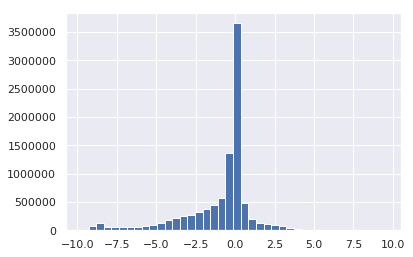

In [8]:
np.log(transactions.watched_ratio).hist(bins = 40);

In [9]:
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)
bookmarks.rename({'ts': 'ts_bookmark'}, axis=1, inplace = True)
bookmarks.head()

,user_uid,element_uid,ts_bookmark
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07


In [10]:
transactions = transactions.merge(bookmarks, 
                                  how = 'left', 
                                  left_on = ['element_uid', 'user_uid'], 
                                  right_on =  ['element_uid', 'user_uid']
                                 )

In [11]:
transactions['is_bookmarked'] = transactions.ts_bookmark.notnull().astype(int)
transactions['ts_difference'] = transactions.ts - transactions.ts_bookmark
transactions.loc[transactions.ts_difference.isnull(), 'ts_difference'] = 0
transactions.head()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,consumption_mode_P,consumption_mode_R,consumption_mode_S,duration,...,feature_3,feature_4,feature_5,type_movie,type_multipart_movie,type_series,watched_ratio,ts_bookmark,is_bookmarked,ts_difference
0,3336,5177,4.430518e+07,4282,0,50,0,0,1,90,...,45,1.141929,0.654707,1,0,0,0.751404,NaN,0,0.0
1,481,593316,4.430518e+07,2989,0,11,0,0,1,50,...,11,1.119409,0.592716,1,0,0,0.906061,NaN,0,0.0
2,4128,262355,4.430518e+07,833,0,50,0,0,1,100,...,12,1.130076,0.654707,1,0,0,0.132381,NaN,0,0.0
3,6272,74296,4.430518e+07,2530,0,99,0,0,1,100,...,34,1.140273,0.680410,1,0,0,0.401746,NaN,0,0.0
4,5543,340623,4.430518e+07,6282,0,50,1,0,0,70,...,14,1.113885,0.000000,1,0,0,1.396222,NaN,0,0.0


In [9]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.float64
    }
)

CPU times: user 219 ms, sys: 4.58 ms, total: 223 ms
Wall time: 248 ms


In [13]:
transactions = transactions.merge(ratings.drop('ts', axis = 1),
                                  how = 'left',
                                  left_on = ['element_uid', 'user_uid'],
                                  right_on =  ['element_uid', 'user_uid']
                                  )

In [14]:
transactions.shape

(9643012, 23)

In [15]:
transactions.head()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer,consumption_mode_P,consumption_mode_R,consumption_mode_S,duration,...,feature_4,feature_5,type_movie,type_multipart_movie,type_series,watched_ratio,ts_bookmark,is_bookmarked,ts_difference,rating
0,3336,5177,4.430518e+07,4282,0,50,0,0,1,90,...,1.141929,0.654707,1,0,0,0.751404,NaN,0,0.0,9.0
1,481,593316,4.430518e+07,2989,0,11,0,0,1,50,...,1.119409,0.592716,1,0,0,0.906061,NaN,0,0.0,NaN
2,4128,262355,4.430518e+07,833,0,50,0,0,1,100,...,1.130076,0.654707,1,0,0,0.132381,NaN,0,0.0,NaN
3,6272,74296,4.430518e+07,2530,0,99,0,0,1,100,...,1.140273,0.680410,1,0,0,0.401746,NaN,0,0.0,NaN
4,5543,340623,4.430518e+07,6282,0,50,1,0,0,70,...,1.113885,0.000000,1,0,0,1.396222,NaN,0,0.0,NaN


In [16]:
train = transactions[transactions.rating.notnull()]
print (train.shape)

(357343, 23)


In [17]:
X = train.drop(['rating', 'element_uid', 'user_uid', 'ts', 'ts_bookmark'], axis = 1)
y = train.rating

In [48]:
%%time

#clf = RandomForestRegressor(n_estimators = 100)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for n in [250]:
    for depth in [5]:
        for sample in [0.8]:
            clf = XGBRegressor(n_estimators = n, max_depth = depth, learning_rate = 0.1, subsample = sample)
            res = cross_val_score(clf, X, y, scoring = 'neg_mean_squared_error', cv = cv, n_jobs = 3)
            print(n, depth, sample, res, res.mean())
    
#neg_mean_squared_error 
#neg_mean_absolute_error

250 5 0.8 [-3.39291408 -3.4174436  -3.45368652 -3.41747097 -3.42582722] -3.42146847858864
CPU times: user 140 ms, sys: 36.7 ms, total: 176 ms
Wall time: 4min 53s


In [ ]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

cv = KFold(n_splits=3, shuffle=True, random_state=42)

xgb = XGBRegressor(n_estimators = 100)
rf = RandomForestRegressor(n_estimators = 100)
gb = GradientBoostingRegressor(n_estimators = 100)
for algo in [xgb, rf, gb]:
    cv_res = cross_validate(algo, X, y, 
                          scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'], cv = cv, n_jobs = 3)
    print(algo, cv_res['fit_time'], cv_res['score_time'], 
          cv_res['test_neg_mean_absolute_error'], cv_res['test_neg_mean_squared_error'],
         cv_res['train_neg_mean_absolute_error'], cv_res['train_neg_mean_squared_error'])    

/home/alexander/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/alexander/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) [32.37613606 32.31650162 24.21659493] [0.81827354 0.82423592 0.91111779] [-1.44394313 -1.44842213 -1.44712538] [-3.50326448 -3.51849087 -3.50256854] [-1.44725125 -1.4424503  -1.44324332] [-3.50167309 -3.49078018 -3.49707178]


In [26]:
sorted(cv_res.keys()) 

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'train_neg_mean_absolute_error',
 'train_neg_mean_squared_error']

In [ ]:
#rf cv=3
50 [-4.18233348 -4.18262571 -4.16689048] -4.177283223895234
100 [-4.1570917 -4.1599165 -4.1363827] -4.1511303000525475
150 [-4.14904227 -4.15325043 -4.13321484] -4.145169181214983

In [ ]:
#xgb cv=3
30 [-3.67239722 -3.67447358 -3.65844536] -3.6684387210319067
50 [-3.53148906 -3.54625175 -3.52987762] -3.5358728111959183
100 [-3.50484482 -3.51956731 -3.50300258] -3.509138239855217
150 [-3.49046114 -3.50433219 -3.48726417] -3.4940191671970258

150 5 0.6 [-3.42948526 -3.4486626  -3.43618027] -3.438109378797332
150 5 0.8 [-3.43107875 -3.44899809 -3.43160261] -3.4372264814898634
150 5 1.0 [-3.43375303 -3.4520153  -3.43596791] -3.4405787465032778

200 5 0.6 [-3.42274715 -3.44345687 -3.42886682] -3.4316902804962233
200 5 0.8 [-3.4225458  -3.44222028 -3.42523074] -3.429998937753585
200 5 1.0 [-3.42480684 -3.44708553 -3.42864351] -3.4335119630741513

250 5 0.6 [-3.4205422  -3.44222565 -3.42437205] -3.42904663194926
250 5 0.8 [-3.41940349 -3.43713398 -3.42145182] -3.4259964278654316
250 5 1.0 [-3.419811   -3.44146884 -3.4241326 ] -3.4284708140608533

In [19]:
%%time
xgb = XGBRegressor(n_estimators = 250, max_depth = 5, learning_rate = 0.1, subsample = 0.8)
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [20]:
pd.DataFrame(zip(X.columns, xgb.feature_importances_), 
             columns = ['feature', 'importance']
            ).sort_values('importance', ascending = False)

,feature,importance
0,watched_time,0.177814
8,feature_2,0.175095
7,feature_1,0.151441
15,watched_ratio,0.147635
9,feature_3,0.080614
6,duration,0.051387
11,feature_5,0.050707
2,device_manufacturer,0.048396
10,feature_4,0.044861
1,device_type,0.030044


In [52]:
%%time
rf = RandomForestRegressor(n_estimators = 150, n_jobs = 3)
rf.fit(X, y)

CPU times: user 10min 36s, sys: 3.13 s, total: 10min 39s
Wall time: 3min 36s


In [53]:
pd.DataFrame(zip(X.columns, rf.feature_importances_), 
             columns = ['feature', 'importance_RF']
            ).sort_values('importance_RF', ascending = False)

,feature,importance_RF
15,watched_ratio,0.295809
0,watched_time,0.295395
8,feature_2,0.160062
7,feature_1,0.046988
9,feature_3,0.036238
2,device_manufacturer,0.032913
11,feature_5,0.027135
1,device_type,0.021072
10,feature_4,0.020100
16,is_bookmarked,0.016322


In [21]:
df_test = transactions[transactions.rating.isnull()]
print(df_test.shape)
df_test.head()

(9285669, 23)


,element_uid,user_uid,ts_x,watched_time,device_type,device_manufacturer,consumption_mode_P,consumption_mode_R,consumption_mode_S,duration,...,feature_4,feature_5,type_movie,type_multipart_movie,type_series,watched_ratio,ts_bookmark,is_bookmarked,rating,ts_y
1,481,593316,4.430518e+07,2989,0,11,0,0,1,50,...,1.119409,0.592716,1,0,0,0.906061,NaN,0,NaN,NaN
2,4128,262355,4.430518e+07,833,0,50,0,0,1,100,...,1.130076,0.654707,1,0,0,0.132381,NaN,0,NaN,NaN
3,6272,74296,4.430518e+07,2530,0,99,0,0,1,100,...,1.140273,0.680410,1,0,0,0.401746,NaN,0,NaN,NaN
4,5543,340623,4.430518e+07,6282,0,50,1,0,0,70,...,1.113885,0.000000,1,0,0,1.396222,NaN,0,NaN,NaN
5,236,332814,4.430518e+07,3109,0,50,0,0,1,120,...,1.140273,0.654707,1,0,0,0.414667,NaN,0,NaN,NaN


In [22]:
X_test = df_test.drop(['rating', 'element_uid', 'user_uid', 'ts_x', 'ts_y', 'ts_bookmark'], axis = 1)

In [23]:
del df_catalogue, ratings, transactions, bookmarks
gc.collect()

4545

In [25]:
%%time
pred_xgb = xgb.predict(X_test)

CPU times: user 2min, sys: 3.15 s, total: 2min 3s
Wall time: 2min 5s


In [38]:
ratings_predicted_xgb = df_test[['element_uid', 'user_uid']].copy()
ratings_predicted_xgb['rating'] = pred_xgb
ratings_predicted_xgb.to_pickle('xgb_ratings.pkl')

In [46]:
ratings_predicted_xgb.head()

,element_uid,user_uid,rating
1,481,593316,8.405955
2,4128,262355,7.914388
3,6272,74296,6.478466
4,5543,340623,8.950354
5,236,332814,8.460540


In [63]:
%%time
pred_rf = rf.predict(X_test)

CPU times: user 12min 51s, sys: 17.3 s, total: 13min 9s
Wall time: 4min 59s


In [65]:
ratings_predicted_rf = df_test[['element_uid', 'user_uid']].copy()
ratings_predicted_rf['rating'] = pred_rf
ratings_predicted_rf.to_pickle('rf_ratings.pkl')

In [68]:
ratings_predicted_rf.head()

,element_uid,user_uid,rating
1,481,593316,7.620000
2,4128,262355,7.643333
3,6272,74296,3.645333
4,5543,340623,9.620000
5,236,332814,9.700000
